In [1]:
import urllib
import time
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import stockstats
import mplfinance as mpf


from datetime import datetime
from pandas_datareader import data
from stockstats import StockDataFrame
from mplfinance.original_flavor import candlestick_ohlc
# from mpl_finance import candlestick_ohlc

In [3]:
## extracting the stock via yahoo api
# stocks = ['SPY']
stocks = ['QQQ']
## stocks = ['XLE']
## starting before 2017 to make sure theres enough data for moving average
start_date = '2016-10-07'
end_date = '2020-09-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
rawDf = data.DataReader(stocks, 'yahoo', start_date, end_date)
rawDf.head(5)

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,,
2016-10-06,114.931694,118.730003,118.980003,118.150002,118.639999,11987100.0
2016-10-07,114.680008,118.470001,119.010002,117.889999,118.839996,19984200.0
2016-10-10,115.406006,119.220001,119.480003,119.029999,119.080002,19687300.0
2016-10-11,113.760384,117.519997,119.139999,117.000000,119.120003,27774400.0
2016-10-12,113.663589,117.419998,117.820000,117.059998,117.629997,14267800.0


In [4]:
## formatting the indexing
rawDf.columns = rawDf.columns.droplevel('Symbols')
rawDf.reset_index(inplace = True)
rawDf.columns.name = None
rawDf.head(5)

,Date,Adj Close,Close,High,Low,Open,Volume
0,2016-10-06,114.931694,118.730003,118.980003,118.150002,118.639999,11987100.0
1,2016-10-07,114.680008,118.470001,119.010002,117.889999,118.839996,19984200.0
2,2016-10-10,115.406006,119.220001,119.480003,119.029999,119.080002,19687300.0
3,2016-10-11,113.760384,117.519997,119.139999,117.000000,119.120003,27774400.0
4,2016-10-12,113.663589,117.419998,117.820000,117.059998,117.629997,14267800.0


In [5]:
## getting simple moving averages
spDf = rawDf.copy()
spDf['SMA3'] = spDf.rolling(3, win_type='triang').mean().Close
spDf['SMA5'] = spDf.rolling(5, win_type='triang').mean().Close
spDf['SMA10'] = spDf.rolling(10, win_type='triang').mean().Close
spDf['SMA30'] = spDf.rolling(30, win_type='triang').mean().Close
spDf['SMA60'] = spDf.rolling(60, win_type='triang').mean().Close

spDf.iloc[58:,:]

,Date,Adj Close,Close,High,Low,Open,Volume,SMA3,SMA5,SMA10,SMA30,SMA60
58,2016-12-29,116.223030,119.709999,120.129997,119.330002,119.849998,13267500.0,120.072498,120.272221,120.271400,118.621333,NaN
59,2016-12-30,115.028862,118.480003,119.949997,118.139999,119.940002,41749000.0,119.445000,119.931110,120.229400,118.772555,117.467667
60,2017-01-03,116.057976,119.540001,119.989998,118.889999,119.269997,22307600.0,119.052502,119.578889,120.135000,118.916111,117.528483
61,2017-01-04,116.689049,120.190002,120.410004,119.660004,119.669998,19749100.0,119.437502,119.334446,119.988200,119.054977,117.593061
62,2017-01-05,117.349251,120.870003,120.949997,120.099998,120.099998,20644300.0,120.197502,119.615557,119.847400,119.189577,117.661545
...,...,...,...,...,...,...,...,...,...,...,...,...
998,2020-09-24,265.390015,265.390015,268.700012,261.220001,261.390015,70631700.0,266.547508,268.115563,270.821002,283.293757,273.410411
999,2020-09-25,271.559998,271.559998,272.399994,264.299988,265.910004,55242400.0,266.625008,267.476674,269.658803,282.419801,273.949062
1000,2020-09-28,277.200012,277.200012,277.200012,271.670013,276.579987,58438300.0,271.427505,268.587786,269.008805,281.437890,274.466689
1001,2020-09-29,275.950012,275.950012,277.709991,275.369995,276.619995,27050000.0,275.477509,271.107785,268.906606,280.441691,274.966967


In [6]:
## using stockdata package for indicators
stocks = StockDataFrame.retype(spDf[["Open", "Close", "High", "Low", "Volume"]])

In [8]:
## adding in columns needed for strategy

## index for reference (just buy and hold) and portfolio for strategy to implement
stockData = spDf.copy()
stockData['Index'] = 1000000.0
stockData['DailyReturnIndex'] = 0.0
stockData['DailyPercReturnIndex'] = 0.0

stockData['Action'] = 0
stockData['Portfolio'] = 1000000.0
stockData['Quantity'] = 0.0
stockData['Remaining'] = 1000000.0
stockData['DailyReturnPort1'] = 0.0
stockData['DailyPercReturnPort1'] = 0.0
stockData['DailyReturnTran'] = 0.0

stockData['Action2'] = 0
stockData['Portfolio2'] = 1000000.0
stockData['Quantity2'] = 0.0
stockData['Remaining2'] = 1000000.0
stockData['DailyReturnPort2'] = 0.0
stockData['DailyPercReturnPort2'] = 0.0
stockData['DailyReturnTran2'] = 0.0
## indicators

# exponential moving averages
stockData['ema3'] = stocks['close_3_ema']
stockData['ema5'] = stocks['close_5_ema']
stockData['ema10'] = stocks['close_10_ema']
stockData['ema20'] = stocks['close_20_ema']
stockData['ema30'] = stocks['close_30_ema']
stockData['ema60'] = stocks['close_60_ema']

## RSI
stockData['RSI'] = stocks['rsi_14'] #the default 14 days
stockData['RSI12'] = stocks['rsi_12']
stockData['RSI7'] = stocks['rsi_7']

# MACD
stockData['MACD'] = stocks['macd']
stockData['MACDS'] = stocks['macds'] #signal
stockData['MACDH'] = stocks['macdh'] #histogram

# bolling
stockData['boll'] = stocks['boll']
stockData['boll_ub'] = stocks['boll_ub']
stockData['boll_lb'] = stocks['boll_lb']

stockData.head(5)

,Date,Adj Close,Close,High,Low,Open,Volume,SMA3,SMA5,SMA10,...,ema60,RSI,RSI12,RSI7,MACD,MACDS,MACDH,boll,boll_ub,boll_lb
0,2016-10-06,114.931694,118.730003,118.980003,118.150002,118.639999,11987100.0,NaN,NaN,NaN,...,118.730003,NaN,NaN,NaN,0.000000,0.000000,0.000000,118.730003,NaN,NaN
1,2016-10-07,114.680008,118.470001,119.010002,117.889999,118.839996,19984200.0,NaN,NaN,NaN,...,118.597836,0.000000,0.000000,0.000000,-0.005833,-0.003241,-0.002593,118.600002,118.967701,118.232304
2,2016-10-10,115.406006,119.220001,119.480003,119.029999,119.080002,19687300.0,118.722502,NaN,NaN,...,118.812175,75.648264,75.885178,77.092366,0.015825,0.004573,0.011252,118.806669,119.568333,118.045004
3,2016-10-11,113.760384,117.519997,119.139999,117.000000,119.120003,27774400.0,118.607500,NaN,NaN,...,118.472802,26.574968,26.381644,25.370428,-0.036091,-0.009202,-0.026889,118.485001,119.914084,117.055917
4,2016-10-12,113.663589,117.419998,117.820000,117.059998,117.629997,14267800.0,117.919998,118.421111,NaN,...,118.247974,25.526012,25.321651,24.253739,-0.067520,-0.026550,-0.040970,118.272000,119.833760,116.710240


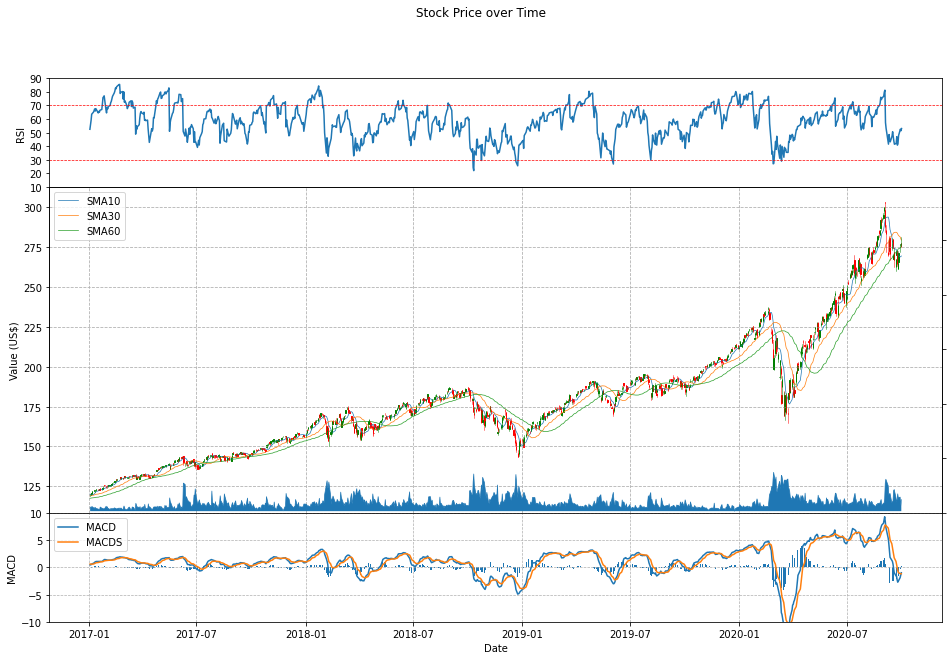

In [9]:
## charting the data with candlestick

length = len(stockData)
candleArr = []
candleArr = stockData.loc[range(60,length),['Date','Open','High','Low','Close']]
# candleArr = candleArr.set_index('Date')

candleArr['Date'] = mdates.date2num(candleArr['Date'].values)
candleArr = candleArr.astype(float)
# x = 0
# while x < length:
#     appendLine = [mdates.date2num(candleArr['Date'][x].values),stockData['Open'][x],stockData['High'][x],stockData['Low'][x],stockData['Close'][x],stockData['Volume'][x]]
#     candleArr.append(appendLine)
#     x+=1

fig = plt.figure(figsize=(16, 10))
# fig,(ax1,ax2) = plt.subplots(2, sharex = True,figsize=(15, 10))



ax0 = plt.subplot2grid((5,4),(0,0), rowspan = 1, colspan = 4)
ax0.tick_params(axis='x')
ax0.tick_params(axis='y')
ax0.set_ylim(10,90)
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(8))
ax0.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['RSI'])
ax0.axhline(70, linestyle = 'dashed', linewidth = 0.7, color = 'r')
ax0.axhline(30, linestyle = 'dashed', linewidth = 0.7, color = 'r')
# ax0.axes.yaxis.set_ticklabels([])
plt.ylabel('RSI')

ax1 = plt.subplot2grid((5,4),(1,0), rowspan = 3, colspan = 4)
# ax1.set_ylim(0.9*stockData.loc[range(60,length)]['Close'].min(),stockData.loc[range(60,length)]['Close'].max())
# ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ax1.spines['top']
# ax1.spines['left']
# ax1.spines['right']
# ax1.spines['bottom']
# ax1.tick_params(axis = 'y')
# ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Index'], label='Index')
# ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Portfolio'], label='Portfolio')
ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['SMA10'], label='SMA10', linewidth=0.7)
ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['SMA30'], label='SMA30', linewidth=0.7)
ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['SMA60'], label='SMA60', linewidth=0.7)

# candlestick_ohlc(ax1, candleArr, width = 0.6, colorup = 'g', colordown = 'r')
candlestick_ohlc(ax1, candleArr.values, width = 0.6, colorup = 'g', colordown = 'r')

plt.ylabel('Value (US$)')
ax1.grid(True, linestyle='dashed')
ax1.legend()
volumeMin = stockData.loc[range(60,length)]['Volume'].min()


ax1v = ax1.twinx()
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0,8*stockData.loc[range(60,length)]['Volume'].max())
# ax2.bar(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Volume'])
ax1v.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Volume'], linewidth = 0.7)
ax1v.fill_between(stockData.loc[range(60,length)].Date,volumeMin, stockData.loc[range(60,length)]['Volume'])
ax1v.grid(False)

ax2 = plt.subplot2grid((5,4),(4,0), sharex = ax1, rowspan = 1, colspan = 4)
# ax2.axes.yaxis.set_ticklabels([])
ax2.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['MACD'], label = 'MACD')
ax2.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['MACDS'], label = 'MACDS')
ax2.bar(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['MACDH'])
# ax1v.fill_between(stockData.loc[range(60,length)].Date,0, stockData.loc[range(60,length)]['MACDH'])
ax2.set_ylim(-10,10)
ax2.legend()
ax2.grid(True, linestyle = 'dashed', linewidth = 0.7)

# ax2.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Volume'], linewidth = 0.7)
# ax2.fill_between(stockData.loc[range(60,length)].Date,volumeMin, stockData.loc[range(60,length)]['Volume'], linewidth = 0.7)
# ax2.get_xaxis().set_visible(False)
# ax2.grid(True,axis='y', linestyle='dashed')
plt.ylabel('MACD')

# date_format = mpl_dates.DateFormatter('%d-%m-%Y')
# ax2.xaxis.set_major_formatter(date_format)

plt.setp(ax1.get_xticklabels(), visible = False)
plt.subplots_adjust(hspace = 0)

plt.xlabel('Date')
plt.suptitle('Stock Price over Time')

plt.show()

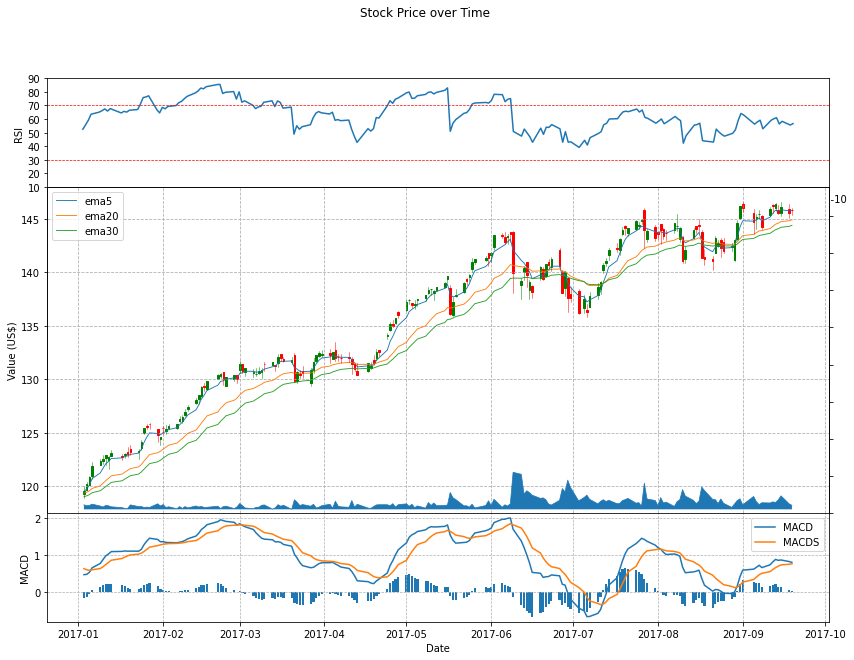

In [10]:

length = 240
candleArr = []
candleArr = stockData.loc[range(60,length),['Date','Open','High','Low','Close']]
# candleArr = candleArr.set_index('Date')

candleArr['Date'] = mdates.date2num(candleArr['Date'].values)
candleArr = candleArr.astype(float)
# x = 0
# while x < length:
#     appendLine = [mdates.date2num(candleArr['Date'][x].values),stockData['Open'][x],stockData['High'][x],stockData['Low'][x],stockData['Close'][x],stockData['Volume'][x]]
#     candleArr.append(appendLine)
#     x+=1

fig = plt.figure(figsize=(14, 10))
# fig,(ax1,ax2) = plt.subplots(2, sharex = True,figsize=(15, 10))



ax0 = plt.subplot2grid((5,4),(0,0), rowspan = 1, colspan = 4)
ax0.tick_params(axis='x')
ax0.tick_params(axis='y')
ax0.set_ylim(10,90)
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(8))
ax0.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['RSI'])
ax0.axhline(70, linestyle = 'dashed', linewidth = 0.7, color = 'r')
ax0.axhline(30, linestyle = 'dashed', linewidth = 0.7, color = 'r')
# ax0.axes.yaxis.set_ticklabels([])
plt.ylabel('RSI')

ax1 = plt.subplot2grid((5,4),(1,0), rowspan = 3, colspan = 4)
# ax1.set_ylim(0.9*stockData.loc[range(60,length)]['Close'].min(),stockData.loc[range(60,length)]['Close'].max())
# ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ax1.spines['top']
# ax1.spines['left']
# ax1.spines['right']
# ax1.spines['bottom']
# ax1.tick_params(axis = 'y')
# ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Index'], label='Index')
# ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Portfolio'], label='Portfolio')
# ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['tema5'], label='tema5', linewidth=0.9)
ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['ema5'], label='ema5', linewidth=0.9)
ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['ema20'], label='ema20', linewidth=0.9)
ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['ema30'], label='ema30', linewidth=0.9)
# ax1.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['tema10'], label='tema10', linewidth=0.9)

# candlestick_ohlc(ax1, candleArr, width = 0.6, colorup = 'g', colordown = 'r')
candlestick_ohlc(ax1, candleArr.values, width = 0.6, colorup = 'g', colordown = 'r')

plt.ylabel('Value (US$)')
ax1.grid(True, linestyle='dashed')
ax1.legend()
volumeMin = stockData.loc[range(60,length)]['Volume'].min()


ax1v = ax1.twinx()
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0,8*stockData.loc[range(60,length)]['Volume'].max())
# ax2.bar(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Volume'])
ax1v.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Volume'], linewidth = 0.7)
ax1v.fill_between(stockData.loc[range(60,length)].Date,volumeMin, stockData.loc[range(60,length)]['Volume'])
ax1v.grid(False)

ax2 = plt.subplot2grid((5,4),(4,0), sharex = ax1, rowspan = 1, colspan = 4)
# ax2.axes.yaxis.set_ticklabels([])
ax2.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['MACD'], label = 'MACD')
ax2.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['MACDS'], label = 'MACDS')
ax2.bar(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['MACDH'])
# ax1v.fill_between(stockData.loc[range(60,length)].Date,0, stockData.loc[range(60,length)]['MACDH'])
# ax2.set_ylim(-10,10)
ax2.legend()
ax2.grid(True, linestyle = 'dashed', linewidth = 0.7)

# ax2.plot(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Volume'], linewidth = 0.7)
# ax2.fill_between(stockData.loc[range(60,length)].Date,volumeMin, stockData.loc[range(60,length)]['Volume'], linewidth = 0.7)
# ax2.get_xaxis().set_visible(False)
# ax2.grid(True,axis='y', linestyle='dashed')
plt.ylabel('MACD')

# date_format = mpl_dates.DateFormatter('%d-%m-%Y')
# ax2.xaxis.set_major_formatter(date_format)

plt.setp(ax1.get_xticklabels(), visible = False)
plt.subplots_adjust(hspace = 0)

plt.xlabel('Date')
plt.suptitle('Stock Price over Time')

plt.show()

In [11]:
## function to signal whether to buy sell
## 1 for buy

def buy_sell_row1(stockData, rowNum):
    flag = 0


    ## if shorter SMA crosses longer SMA from below, buy
    if stockData['SMA3'][rowNum-1] < stockData['SMA5'][rowNum-1] and stockData['SMA3'][rowNum] > stockData['SMA5'][rowNum]:
        flag = 1
    
    ## if shorter SMA crosses longer SMA from above, sell
    elif stockData['SMA3'][rowNum-1] > stockData['SMA10'][rowNum-1] and stockData['SMA3'][rowNum] < stockData['SMA10'][rowNum]:
        flag = 2

    ## if upward
    elif stockData['Close'][rowNum] > stockData['Close'][rowNum-1] and stockData['SMA3'][rowNum] > stockData['SMA30'][rowNum] and stockData['Quantity'][rowNum] == 0:
        flag = 1
    
    return (flag)

In [12]:
## function to signal whether to buy sell
def buy_sell_row2(stockData, rowNum):
    flag = 0
    rsiFlag = 0
    macdHistFlag = 0
    macdCross = 0
    ema3Flag = 0
    ema5Flag = 0
    ema10Flag = 0
    ema20Flag = 0
    priceEmaFlag = 0
    remaining = stockData['Remaining2'][rowNum]
    quantity = stockData['Quantity2'][rowNum]

    ## getting the flags for RSI MACD and price
    if stockData['RSI'][rowNum] >= 70:
        rsiFlag = 1
    elif stockData['RSI'][rowNum] <= 30:
        rsiFlag = -1
    if stockData['MACDH'][rowNum] >= 0:
        macdHistFlag = 1
    # 1 for macd crossing macds from above
    if stockData['MACD'][rowNum-1] > stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] <= stockData['MACDS'][rowNum]:
        macdCross = 1
    elif stockData['MACD'][rowNum-1] < stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] >= stockData['MACDS'][rowNum]:
        macdCross = 2
    # 1 for macd crossing macds from above
    if stockData['MACD'][rowNum-1] > stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] <= stockData['MACDS'][rowNum]:
        macdCross = 1
    elif stockData['MACD'][rowNum-1] < stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] >= stockData['MACDS'][rowNum]:
        macdCross = 2
    # 1 for ema5 crossing ema10 from above
    if stockData['ema5'][rowNum-1] > stockData['ema10'][rowNum-1] and stockData['ema5'][rowNum] <= stockData['ema10'][rowNum]:
        ema3Flag = 1
    elif stockData['ema5'][rowNum-1] < stockData['ema10'][rowNum-1] and stockData['ema5'][rowNum] >= stockData['ema10'][rowNum]:
        ema3Flag = 2
    # 1 for em3 crossing ema5 from above
    if stockData['ema3'][rowNum-1] > stockData['ema5'][rowNum-1] and stockData['ema3'][rowNum] <= stockData['ema5'][rowNum]:
        ema5Flag = 1
    elif stockData['ema3'][rowNum-1] < stockData['ema5'][rowNum-1] and stockData['ema3'][rowNum] >= stockData['ema5'][rowNum]:
        ema5Flag = 2
    # 1 for em3 crossing ema10 from above
    if stockData['ema3'][rowNum-1] > stockData['ema10'][rowNum-1] and stockData['ema3'][rowNum] <= stockData['ema10'][rowNum]:
        ema10Flag = 1
    elif stockData['ema3'][rowNum-1] < stockData['ema10'][rowNum-1] and stockData['ema3'][rowNum] >= stockData['ema10'][rowNum]:
        ema10Flag = 2
    # 1 for em3 crossing ema20 from above
    if stockData['ema5'][rowNum-1] > stockData['ema20'][rowNum-1] and stockData['ema5'][rowNum] <= stockData['ema20'][rowNum]:
        ema20Flag = 1
    elif stockData['ema5'][rowNum-1] < stockData['ema20'][rowNum-1] and stockData['ema5'][rowNum] >= stockData['ema20'][rowNum]:
        ema20Flag = 2
    # 1 for price crossing ema10 from above
    if stockData['Close'][rowNum-1] > stockData['ema10'][rowNum-1] and stockData['Close'][rowNum] <= stockData['ema10'][rowNum]:
        priceEmaFlag = 1
    elif stockData['Close'][rowNum-1] < stockData['ema10'][rowNum-1] and stockData['Close'][rowNum] >= stockData['ema10'][rowNum]:
        priceEmaFlag = 2

    ## selling
    if quantity > 0:
        if rsiFlag == 1:
            if macdCross == 1 or ema5Flag == 1:
                flag = 2
        elif macdCross == 1 and stockData['ema3'][rowNum] < stockData['ema5'][rowNum]:
            flag = 2
        elif ema3Flag == 1 and stockData['MACD'][rowNum] < stockData['MACDS'][rowNum]:
            flag = 2
        elif ema20Flag == 1 and stockData['ema3'][rowNum] < stockData['ema20'][rowNum]:
            flag = 2 

    ## only buying if remaining
    if remaining > 0 and flag == 0:
        # more bold actions if oversold
        if rsiFlag == -1:
            if macdCross == 2 or ema5Flag == 2:
                flag = 1
        elif macdCross == 2 and stockData['ema3'][rowNum] >= stockData['ema5'][rowNum]:
            flag = 1
        elif ema5Flag == 2 and stockData['MACD'][rowNum] >= stockData['MACDS'][rowNum]:
            flag = 1
        elif ema5Flag == 2 and stockData['Close'][rowNum] >= stockData['ema3'][rowNum]:
            flag = 1
        #for long term
        elif stockData['ema3'][rowNum] >= stockData['ema20'][rowNum] :
            flag = 1
        
        ## if everything trending upward with additional capital remaining (mostly for starting at upward)
        elif stockData['MACD'][rowNum] > stockData['MACDS'][rowNum] and stockData['Close'][rowNum] > stockData['ema5'][rowNum]:
            flag = 1
    return (flag)

In [13]:
def amount_row(stockData, rowNum, flag):
    ## return remaining capital if to buy
    if flag == 1:
        if stockData['Remaining'][rowNum] > 0:
            return stockData['Remaining'][rowNum]
        else:
            return 0
    
    ## return value of asset holdings if to sell
    elif flag == 2:
        if stockData['Quantity'][rowNum] > 0:
            return stockData['Quantity'][rowNum]*stockData['Close'][rowNum]
        else:
            return 0
    
    else:
        return 0
    

In [14]:
def amount_row2(stockData, rowNum, flag):
    ## return remaining capital if to buy
    if flag == 1:
        if stockData['Remaining2'][rowNum] > 0:
            return stockData['Remaining2'][rowNum]
        else:
            return 0
    
    ## return value of asset holdings if to sell
    elif flag == 2:
        if stockData['Quantity2'][rowNum] > 0:
            return stockData['Quantity2'][rowNum]*stockData['Close'][rowNum]
        else:
            return 0
    
    else:
        return 0

In [15]:
def amount_row3(stockData, rowNum, flag):
 
    rsiFlag = 0
    macdHistFlag = 0
    macdCross = 0
    ema3Flag = 0
    ema5Flag = 0
    ema10Flag = 0
    ema20Flag = 0
    priceEmaFlag = 0
    remaining = stockData['Remaining'][rowNum]
    quantity = stockData['Quantity'][rowNum]

    ## getting the flags for RSI MACD and price
    if stockData['RSI'][rowNum] >= 70:
        rsiFlag = 1
    elif stockData['RSI'][rowNum] <= 30:
        rsiFlag = -1

    if stockData['MACDH'][rowNum] >= 0:
        macdHistFlag = 1
    # 1 for macd crossing macds from above
    if stockData['MACD'][rowNum-1] > stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] <= stockData['MACDS'][rowNum]:
        macdCross = 1
    elif stockData['MACD'][rowNum-1] < stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] >= stockData['MACDS'][rowNum]:
        macdCross = 2

    # 1 for macd crossing macds from above
    if stockData['MACD'][rowNum-1] > stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] <= stockData['MACDS'][rowNum]:
        macdCross = 1
    elif stockData['MACD'][rowNum-1] < stockData['MACDS'][rowNum-1] and stockData['MACD'][rowNum] >= stockData['MACDS'][rowNum]:
        macdCross = 2
    
    # 1 for price crossing ema from above
    if stockData['ema5'][rowNum-1] > stockData['ema10'][rowNum-1] and stockData['ema5'][rowNum] <= stockData['ema10'][rowNum]:
        ema3Flag = 1
    elif stockData['ema5'][rowNum-1] < stockData['ema10'][rowNum-1] and stockData['ema5'][rowNum] >= stockData['ema10'][rowNum]:
        ema3Flag = 2
    # 1 for em3 crossing ema5 from above
    if stockData['ema3'][rowNum-1] > stockData['ema5'][rowNum-1] and stockData['ema3'][rowNum] <= stockData['ema5'][rowNum]:
        ema5Flag = 1
    elif stockData['ema3'][rowNum-1] < stockData['ema5'][rowNum-1] and stockData['ema3'][rowNum] >= stockData['ema5'][rowNum]:
        ema5Flag = 2
    # 1 for em3 crossing ema10 from above
    if stockData['ema3'][rowNum-1] > stockData['ema10'][rowNum-1] and stockData['ema3'][rowNum] <= stockData['ema10'][rowNum]:
        ema10Flag = 1
    elif stockData['ema3'][rowNum-1] < stockData['ema10'][rowNum-1] and stockData['ema3'][rowNum] >= stockData['ema10'][rowNum]:
        ema10Flag = 2
    # 1 for em3 crossing ema10 from above
    if stockData['ema5'][rowNum-1] > stockData['ema20'][rowNum-1] and stockData['ema5'][rowNum] <= stockData['ema20'][rowNum]:
        ema20Flag = 1
    elif stockData['ema5'][rowNum-1] < stockData['ema20'][rowNum-1] and stockData['ema5'][rowNum] >= stockData['ema20'][rowNum]:
        ema20Flag = 2
    
    # 1 for em3 crossing ema5 from above
    if stockData['Close'][rowNum-1] > stockData['ema10'][rowNum-1] and stockData['Close'][rowNum] <= stockData['ema10'][rowNum]:
        priceEmaFlag = 1
    elif stockData['Close'][rowNum-1] < stockData['ema10'][rowNum-1] and stockData['Close'][rowNum] >= stockData['ema10'][rowNum]:
        priceEmaFlag = 2

    
    ## return buy/sell (weak/strong)
    buyratio = 0.6
    sellratio = 0.6

    ## if buying and there are remaining capital
    if flag == 1 and stockData['Remaining2'][rowNum] > 0:
        if stockData['ema3'][rowNum] > stockData['ema5'][rowNum]:
            return stockData['Remaining2'][rowNum]
        else:
            if stockData['Remaining2'][rowNum] <= (stockData['Portfolio2'][rowNum]*buyratio):
                return stockData['Remaining2'][rowNum]
            else:
                return stockData['Remaining2'][rowNum]*buyratio
    
    ## return value of asset holdings if to sell
    elif flag == 2 and stockData['Quantity2'][rowNum] > 0:
        holdingVal = stockData['Quantity2'][rowNum]*stockData['Close'][rowNum]
        if stockData['ema3'][rowNum] < stockData['ema5'][rowNum]:
            return holdingVal
        else:
            if holdingVal <= (stockData['Portfolio2'][rowNum]*sellratio):
                return holdingVal
            else:
                return holdingVal*sellratio
    
    else:
        return 0
    

In [16]:
## looping through the data
start = 60

for i in range(start, len(stockData)):
    ## index 
    ## index valuation
    if i >= 60:
        stockData['Index'][i] = stockData['Close'][i]*1000000/stockData['Close'][60]
    
    stockData['DailyReturnIndex'][i] = stockData['Index'][i] - stockData['Index'][i-1]
    stockData['DailyPercReturnIndex'][i] = stockData['DailyReturnIndex'][i]/stockData['Index'][i-1]
    
    ## portfolio 1
    buySellSignal = buy_sell_row1(stockData, i-1)
    buySellQuantity = amount_row(stockData, i-1, buySellSignal)
    stockData['Action'][i] = buySellSignal
    
    if buySellSignal == 1:
        stockData['Quantity'][i] = stockData['Quantity'][i-1] + buySellQuantity/(stockData['Close'][i-1])
        stockData['Remaining'][i] = stockData['Remaining'][i-1] - buySellQuantity
        
    elif buySellSignal == 2: 
        stockData['Quantity'][i] = stockData['Quantity'][i-1] - buySellQuantity/(stockData['Close'][i-1])
        stockData['Remaining'][i] = stockData['Remaining'][i-1] + buySellQuantity

    ## otherwise hold
    else:
        stockData['Quantity'][i] =  stockData['Quantity'][i-1]
        stockData['Remaining'][i] =  stockData['Remaining'][i-1]
    
    stockData['Portfolio'][i] = stockData['Remaining'][i] + stockData['Quantity'][i]*stockData['Close'][i]
    stockData['DailyReturnTran'][i] = stockData['DailyReturnTran'][i-1] + abs(stockData['Remaining'][i] - stockData['Remaining'][i-1])
    stockData['DailyReturnPort1'][i] = stockData['Portfolio'][i] - stockData['Portfolio'][i-1]
    stockData['DailyPercReturnPort1'][i] = stockData['DailyReturnPort1'][i]/stockData['Portfolio'][i-1]


    ## portfolio 2
    buySellSignal2 = buy_sell_row2(stockData, i-1)
    buySellQuantity2 = amount_row3(stockData, i-1, buySellSignal2)
    stockData['Action2'][i] = buySellSignal2
    # print(buySellSignal,buySellQuantity)

    if buySellSignal2 == 1:
        stockData['Quantity2'][i] = stockData['Quantity2'][i-1] + buySellQuantity2/(stockData['Close'][i-1])
        stockData['Remaining2'][i] = stockData['Remaining2'][i-1] - buySellQuantity2
        
    elif buySellSignal2 == 2: 
        stockData['Quantity2'][i] = stockData['Quantity2'][i-1] - buySellQuantity2/(stockData['Close'][i-1])
        stockData['Remaining2'][i] = stockData['Remaining2'][i-1] + buySellQuantity2

    ## otherwise hold
    else:
        stockData['Quantity2'][i] =  stockData['Quantity2'][i-1]
        stockData['Remaining2'][i] =  stockData['Remaining2'][i-1]
    
    # print('i = {:.0f} :| {:.0f}   | {:07.0f} | {:04.0f} | {:08.0f} |'.format(i, buySellSignal2, buySellQuantity2, stockData['Quantity2'][i],  stockData['Remaining2'][i] ))
    
    stockData['Portfolio2'][i] = stockData['Remaining2'][i] + stockData['Quantity2'][i]*stockData['Close'][i]
    stockData['DailyReturnTran2'][i] = stockData['DailyReturnTran2'][i-1] + abs(stockData['Remaining2'][i] - stockData['Remaining2'][i-1])
    stockData['DailyReturnPort2'][i] = stockData['Portfolio2'][i] - stockData['Portfolio2'][i-1]
    stockData['DailyPercReturnPort2'][i] = stockData['DailyReturnPort2'][i]/stockData['Portfolio2'][i-1]
    

# print(stockData['Portfolio'][len(stockData)-1])
# print(stockData['Portfolio2'][len(stockData)-1])
stockData.iloc[60:68, 10:30]

,SMA30,SMA60,Index,DailyReturnIndex,DailyPercReturnIndex,Action,Portfolio,Quantity,Remaining,DailyReturnPort1,DailyPercReturnPort1,DailyReturnTran,Action2,Portfolio2,Quantity2,Remaining2,DailyReturnPort2,DailyPercReturnPort2,DailyReturnTran2,ema3
60,118.916111,117.528483,1.000000e+06,0.000000,0.000000,0,1.000000e+06,0.000000,1000000.0,0.000000,0.000000,0.0,0,1.000000e+06,0.000000,1000000.0,0.000000,0.000000,0.0,119.378784
61,119.054977,117.593061,1.005438e+06,5437.523180,0.005438,1,1.005438e+06,8365.400639,0.0,5437.523180,0.005438,1000000.0,1,1.003263e+06,5019.240383,400000.0,3262.513908,0.003263,600000.0,119.784393
62,119.189577,117.661545,1.011126e+06,5688.474987,0.005658,1,1.011126e+06,8365.400639,0.0,5688.474987,0.005658,1000000.0,1,1.008939e+06,8347.304214,0.0,5676.169413,0.005658,1000000.0,120.327198
63,119.321733,117.732617,1.019993e+06,8867.304254,0.008770,0,1.019993e+06,8365.400639,0.0,8867.304254,0.008770,1000000.0,0,1.017787e+06,8347.304214,0.0,8848.122088,0.008770,1000000.0,121.128599
64,119.454689,117.806222,1.023339e+06,3346.173020,0.003281,0,1.023339e+06,8365.400639,0.0,3346.173020,0.003281,1000000.0,0,1.021126e+06,8347.304214,0.0,3338.934423,0.003281,1000000.0,121.729301
65,119.592422,117.882556,1.025598e+06,2258.630090,0.002207,0,1.025598e+06,8365.400639,0.0,2258.630090,0.002207,1000000.0,0,1.023379e+06,8347.304214,0.0,2253.744117,0.002207,1000000.0,122.164649
66,119.737889,117.961672,1.028359e+06,2760.597528,0.002692,0,1.028359e+06,8365.400639,0.0,2760.597528,0.002692,1000000.0,0,1.026134e+06,8347.304214,0.0,2754.625675,0.002692,1000000.0,122.547325
67,119.887489,118.043395,1.026769e+06,-1589.446545,-0.001546,0,1.026769e+06,8365.400639,0.0,-1589.446545,-0.001546,1000000.0,0,1.024548e+06,8347.304214,0.0,-1586.008180,-0.001546,1000000.0,122.643661


In [17]:
## functions for performance metrics
def profitCalc(totalVal):
    profit = totalVal/1000000 - 1
    return profit
def sharpeCalc(percReturn):
    sharpe = percReturn.mean()/percReturn.std() * (252**0.5)
    return sharpe
def sortinoCalc(percReturn, target):
    downReturn = percReturn.copy()
    downReturn[percReturn < target] = percReturn**2
    downReturn[percReturn >= target] = 0
    sortino = percReturn.mean()/np.sqrt(downReturn.mean()) 
    return sortino* (252**0.5)
def romadCalc(profit, percReturn):
    s = (percReturn + 1).cumprod()
    romad = profit/(np.ptp(s)/s.max())
    return romad


In [18]:
## output performance metrics
stockDataSum = stockData.loc[range(60,len(stockData))]

indexVal = stockData['Close'][len(stockData)-1]*1000000/stockData['Close'][59]
port1Val = stockData['Portfolio'][len(stockData)-1]
port2Val = stockData['Portfolio2'][len(stockData)-1]

print("  SPY       | Index     | Portfolio1 | Portfolio2")
print(" ------------------------------------------------")
print("Total Value:| {:.0f}   | {:.0f}    | {:.0f}".format(indexVal,port1Val,port2Val))
print("Profit:     | {:.2f}%    | {:.2f}%     | {:.2f}%".format(profitCalc(indexVal)*100,profitCalc(port1Val)*100,profitCalc(port2Val)*100))
print("Sharpe:     | {:.3f}     | {:.3f}      | {:.3f}".format(sharpeCalc(stockDataSum['DailyPercReturnIndex']),sharpeCalc(stockDataSum['DailyPercReturnPort1']),sharpeCalc(stockDataSum['DailyPercReturnPort2'])))
print("Sortino:    | {:.3f}     | {:.3f}      | {:.3f}".format(sortinoCalc(stockDataSum['DailyPercReturnIndex'],0),sortinoCalc(stockDataSum['DailyPercReturnPort1'],0),sortinoCalc(stockDataSum['DailyPercReturnPort2'],0)))
print("RoMaD:      | {:.3f}     | {:.3f}      | {:.3f}".format(romadCalc(profitCalc(indexVal),stockDataSum['DailyPercReturnIndex']),romadCalc(profitCalc(port1Val),stockDataSum['DailyPercReturnPort2']),romadCalc(profitCalc(port2Val),stockDataSum['DailyPercReturnPort2'])))


  SPY       | Index     | Portfolio1 | Portfolio2
 ------------------------------------------------
Total Value:| 2345037   | 2046078    | 1924920
Profit:     | 134.50%    | 104.61%     | 92.49%
Sharpe:     | 1.083     | 1.223      | 0.984
Sortino:    | 1.507     | 1.720      | 1.361
RoMaD:      | 2.223     | 2.083      | 1.842


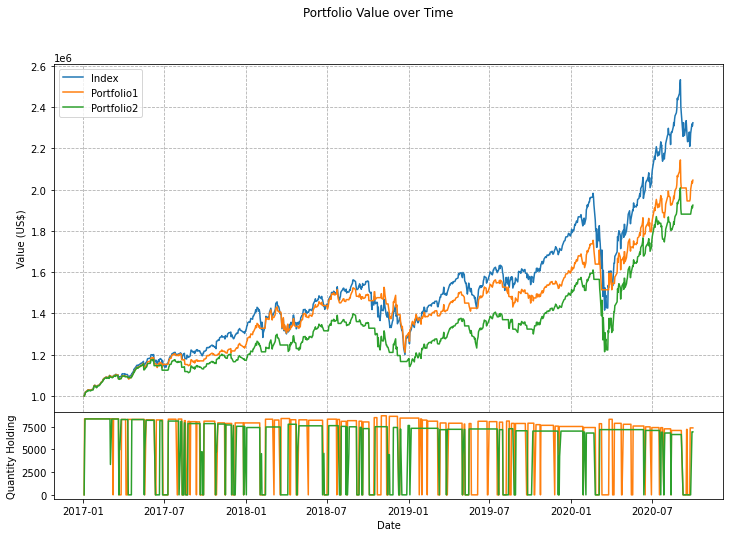

In [19]:
## chart of value over time

start = 60
length = len(stockData)


fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((5,4),(0,0), rowspan = 4, colspan = 4)

ax1.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['Index'], label='Index')
ax1.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['Portfolio'], label='Portfolio1')
ax1.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['Portfolio2'], label='Portfolio2')


plt.ylabel('Value (US$)')
ax1.grid(True, linestyle='dashed')
ax1.legend()


ax2 = plt.subplot2grid((5,4),(4,0), sharex = ax1, rowspan = 1, colspan = 4)
# ax2.bar(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['Volume'])
ax2.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['Quantity'], label='Portfolio1', color = '#ff7f0e')
ax2.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['Quantity2'], label='Portfolio2', color = '#2ca02c')
plt.ylabel('Quantity Holding')

plt.setp(ax1.get_xticklabels(), visible = False)
plt.subplots_adjust(hspace = 0)

plt.xlabel('Date')
plt.suptitle('Portfolio Value over Time')

plt.show()

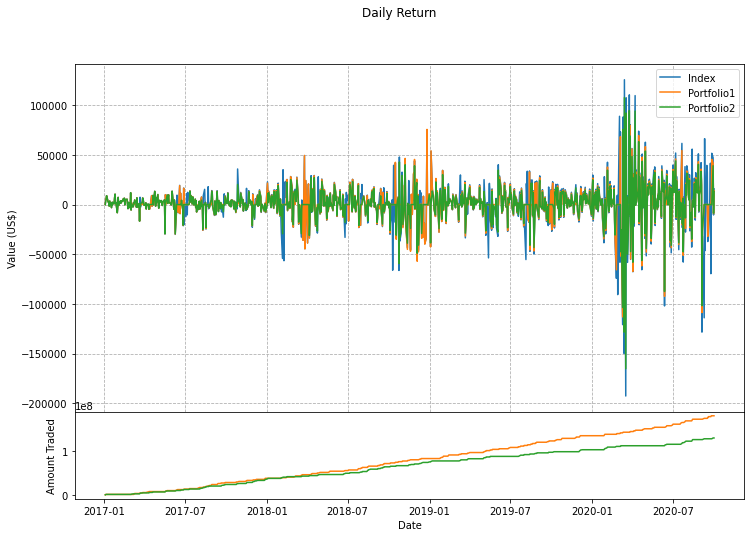

In [20]:
## chart for daily return
start = 60
length = len(stockData)

fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((5,4),(0,0), rowspan = 4, colspan = 4)

ax1.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['DailyReturnIndex'], label='Index')
ax1.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['DailyReturnPort1'], label='Portfolio1')
ax1.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['DailyReturnPort2'], label='Portfolio2')



plt.ylabel('Value (US$)')
ax1.grid(True, linestyle='dashed')
ax1.legend()


ax2 = plt.subplot2grid((5,4),(4,0), sharex = ax1, rowspan = 1, colspan = 4)
ax2.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['DailyReturnTran'], label='Portfolio1', color = '#ff7f0e')
ax2.plot(stockData.loc[range(start,length)].Date, stockData.loc[range(start,length)]['DailyReturnTran2'], label='Portfolio2', color = '#2ca02c')
plt.ylabel('Amount Traded')

# date_format = mpl_dates.DateFormatter('%d-%m-%Y')
# ax2.xaxis.set_major_formatter(date_format)

plt.setp(ax1.get_xticklabels(), visible = False)
plt.subplots_adjust(hspace = 0)

plt.xlabel('Date')
plt.suptitle('Daily Return')

plt.show()

<Figure size 1080x720 with 0 Axes>

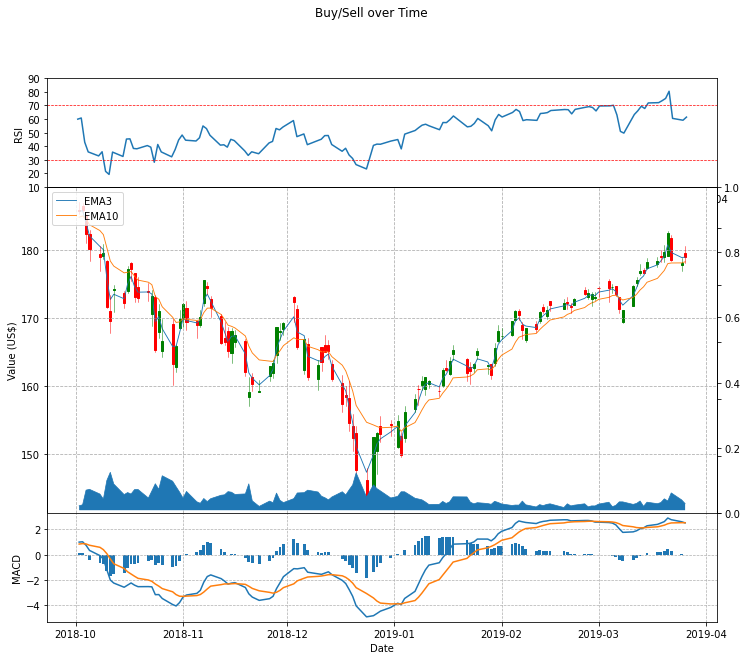

In [21]:

## view buy sell

plt.figure(figsize=(15, 10))
start = 500
end = 620
# len(stockData)-90
stockDataExtract = stockData.loc[range(start,end)]
stockDataBuy = []
stockDataSell = []
for i in range(start,end):
    if stockDataExtract['Action2'][i] == 1:
        stockDataBuy.append(stockDataExtract['Low'][i] - stockDataExtract['Low'][i]/100)
        stockDataSell.append(np.nan)

    elif stockDataExtract['Action2'][i] == 2:
        stockDataBuy.append(np.nan)
        stockDataSell.append(stockDataExtract['High'][i] + stockDataExtract['Low'][i]/100)

    else:
        stockDataBuy.append(np.nan)
        stockDataSell.append(np.nan)
# print(stockDataBuy)



length = len(stockDataExtract)
candleArr2 = []
candleArr2 = stockDataExtract.loc[:,['Date','Open','High','Low','Close']]
# candleArr = candleArr.set_index('Date')

candleArr2['Date'] = mdates.date2num(candleArr2['Date'].values)
candleArr2 = candleArr2.astype(float)
# x = 0
# while x < length:
#     appendLine = [mdates.date2num(candleArr['Date'][x].values),stockData['Open'][x],stockData['High'][x],stockData['Low'][x],stockData['Close'][x],stockData['Volume'][x]]
#     candleArr.append(appendLine)
#     x+=1

fig = plt.figure(figsize=(12, 10))
# fig,(ax1,ax2) = plt.subplots(2, sharex = True,figsize=(15, 10))



ax0 = plt.subplot2grid((5,4),(0,0), rowspan = 1, colspan = 4)
ax0.tick_params(axis='x')
ax0.tick_params(axis='y')
ax0.plot(stockDataExtract.Date, stockDataExtract['RSI12'])
ax0.set_ylim(10,90)
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(8))
ax0.axhline(70, linestyle = 'dashed', linewidth = 0.7, color = 'r')
ax0.axhline(30, linestyle = 'dashed', linewidth = 0.7, color = 'r')
# plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='lower'))

plt.ylabel('RSI')

ax1 = plt.subplot2grid((5,4),(1,0), rowspan = 3, colspan = 4)
ax1.plot(stockDataExtract.Date, stockDataExtract['ema3'], label='EMA3', linewidth=0.9)
# ax1.plot(stockDataExtract.Date, stockDataExtract['ema5'], label='EMA5', linewidth=0.9)
ax1.plot(stockDataExtract.Date, stockDataExtract['ema10'], label='EMA10', linewidth=0.9)
# ax1.plot(stockDataExtract.Date, stockDataExtract['ema20'], label='EMA20', linewidth=0.9)
# ax1.plot(stockDataExtract.Date, stockDataExtract['SMA60'], label='SMA60', linewidth=0.7)

# ax1.scatter(stockDataExtract.Date, stockDataBuy, label='Buy', marker = '^', color = 'green', s = 40)
# ax1.scatter(stockDataExtract.Date, stockDataSell, label='Sell', marker = 'v', color = 'red', s = 40)

# candlestick_ohlc(ax1, candleArr, width = 0.6, colorup = 'g', colordown = 'r')
candlestick_ohlc(ax1, candleArr2.values, width = 0.6, colorup = 'g', colordown = 'r')

plt.ylabel('Value (US$)')
ax1.grid(True, linestyle='dashed')
ax1.legend(loc='upper left')

ax1v = ax1.twinx()
ax1v = ax1.twinx()
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0,8*stockDataExtract['Volume'].max())
# ax2.bar(stockData.loc[range(60,length)].Date, stockData.loc[range(60,length)]['Volume'])
ax1v.plot(stockDataExtract.Date, stockDataExtract['Volume'], linewidth = 0.7)
ax1v.fill_between(stockDataExtract.Date,volumeMin, stockDataExtract['Volume'])
ax1v.grid(False)


ax2 = plt.subplot2grid((5,4),(4,0), sharex = ax1, rowspan = 1, colspan = 4)
ax2.plot(stockDataExtract.Date, stockDataExtract['MACD'])
ax2.plot(stockDataExtract.Date, stockDataExtract['MACDS'])
ax2.bar(stockDataExtract.Date, stockDataExtract['MACDH'])
# ax2.set_ylim(stockDataExtract.min,10)
ax2.grid(True, linestyle = 'dashed', linewidth = 0.7)

plt.ylabel('MACD')

plt.setp(ax1.get_xticklabels(), visible = False)
plt.subplots_adjust(hspace = 0)

plt.xlabel('Date')
plt.suptitle('Buy/Sell over Time')

plt.show()

In [22]:
## output performance metrics
cost = 0.001

indexVal = stockData['Close'][len(stockData)-1]*1000000/stockData['Close'][59]
port1Val = stockData['Portfolio'][len(stockData)-1]
port2Val = stockData['Portfolio2'][len(stockData)-1]
indexTrade = 1000000 
port1Trade = stockData['DailyReturnTran'][len(stockData)-1]
port2Trade = stockData['DailyReturnTran2'][len(stockData)-1]
indexNet = indexVal-indexTrade*cost
port1Net = port1Val-port1Trade*cost
port2Net = port2Val-port2Trade*cost

print("            | Index     | Portfolio1 | Portfolio2")
print(" ------------------------------------------------")
print("Total Value:| {:.0f}   | {:.0f}    | {:.0f}".format(indexVal,port1Val,port2Val))
print("Profit:     | {:.3f}%   | {:.3f}%    | {:.3f}%".format(profitCalc(indexVal)*100,profitCalc(port1Val)*100,profitCalc(port2Val)*100))
print("Traded:     | {:.0f}   | {:.0f}  | {:.0f}".format(indexTrade,port1Trade,port2Trade))
print("0.1% Cost:  | {:.0f}      | {:.0f}     | {:.0f}".format(indexTrade*cost,port1Trade*cost,port2Trade*cost))
print("Net Value:  | {:.0f}   | {:.0f}    | {:.0f}".format(indexNet,port1Net,port2Net))
print("Net Profit: | {:.3f}%   | {:.3f}%    | {:.3f}%".format(indexNet/10000 - 100,port1Net/10000 - 100,port2Net/10000 - 100))

            | Index     | Portfolio1 | Portfolio2
 ------------------------------------------------
Total Value:| 2345037   | 2046078    | 1924920
Profit:     | 134.504%   | 104.608%    | 92.492%
Traded:     | 1000000   | 182393799  | 131209361
0.1% Cost:  | 1000      | 182394     | 131209
Net Value:  | 2344037   | 1863684    | 1793710
Net Profit: | 134.404%   | 86.368%    | 79.371%
